In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

In [9]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
import numpy as np
import pyspark.sql.functions as F
from pyspark.sql.types import ArrayType, DoubleType
from pyspark.mllib.evaluation import RegressionMetrics
import sys
import matplotlib.pyplot as plt
from pyspark.sql.functions import when
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("Jena_Climate").getOrCreate()

In [10]:
# # LSTM class
class LSTM:
    def __init__(self, input_d, hidden_d,sequence_length, output_d,lambda_param):
      # Initialize weights and biases
      self.wt_f,self.bias_fd = self.weights_generation(hidden_d,input_d + hidden_d),self.bias_generation((hidden_d, 1))
      self.wt_i,self.bias_id = self.weights_generation(hidden_d,input_d + hidden_d),self.bias_generation((hidden_d,1))
      self.wt_c,self.bias_cd = self.weights_generation(hidden_d,input_d + hidden_d),self.bias_generation((hidden_d,1))
      self.wt_o,self.bias_od = self.weights_generation(hidden_d,input_d + hidden_d),self.bias_generation((hidden_d,1))
      self.wt_out,self.bias_odut = self.weights_generation(output_d, hidden_d),self.bias_generation((output_d, 1))

      #param
      self.sequence_length = sequence_length
      self.lambda_param = lambda_param
      self.hidden_d = hidden_d

      # Normalise weights
      self.wt_f /= self.normalise(self.wt_f ** 2)
      self.wt_i /= self.normalise(self.wt_i ** 2)
      self.wt_c /= self.normalise(self.wt_c ** 2)
      self.wt_o /= self.normalise(self.wt_o ** 2)
      self.wt_out /= self.normalise(self.wt_out ** 2)

      # store forward gate values
      self.gatef = [self.bias_generation((hidden_d,1)) for _ in range(sequence_length)]
      self.gatei = [self.bias_generation((hidden_d,1)) for _ in range(sequence_length)]
      self.gatect = [self.bias_generation((hidden_d,1)) for _ in range(sequence_length)]
      self.gateo = [self.bias_generation((hidden_d,1)) for _ in range(sequence_length)]
      self.gatec = [self.bias_generation((hidden_d,1)) for _ in range(sequence_length)]
      self.gateh = [self.bias_generation((hidden_d,1)) for _ in range(sequence_length)]

    def sigm_func(self,t):
      return 1 / (1 + np.exp(-t))

    def weights_generation(self, g1, g2):
      return np.random.randn(g1 , g2)

    def bias_generation(self,s):
      return np.zeros(s)

    def normalise(self,t):
      return np.sqrt(np.sum(t ** 2))

    def forward(self, inputx):
      # concatenate values
      for r in range(self.sequence_length):
        stack = np.vstack((self.gateh[r-1], inputx[r]))
        # gates compute and store
        f = self.sigm_func(np.dot(self.wt_f, stack) + self.bias_fd)
        self.gatef[r] = f
        i = self.sigm_func(np.dot(self.wt_i, stack) + self.bias_id)
        self.gatei[r],self.gatect[r] = i,i
        ct = np.tanh(np.dot(self.wt_c, stack) + self.bias_cd)
        c = f * self.gatec[r-1] + i * ct
        self.gatec[r] = c
        o = self.sigm_func(np.dot(self.wt_o, stack) + self.bias_od)
        self.gateo[r] = o
        h = o * np.tanh(c)
        self.gateh[r] = h
      predy = np.dot(self.wt_out,self.gateh[-1])+self.bias_odut
      return predy

    def backward(self,x,delta):
      delta_wy = delta * self.gateh[-1].T
      delta_by = delta

      dt_h = [self.bias_generation((self.hidden_d,1)) for _ in range(self.sequence_length+1)]
      loop_range=reversed(range(self.sequence_length))
      for r in loop_range:
        dt_h[r] = np.dot(self.wt_out.T,delta) + dt_h[r+1]
        grd_od = dt_h[r] * np.tanh(self.gatec[r])
        grd_cd = dt_h[r] * self.gateo[r] * (1- np.tanh(self.gatec[r]) ** 2)
        grd_gd = dt_h[r] * self.gateo[r] * (1- np.tanh(self.gatec[r]) ** 2)
        grd_fd = dt_h[r] * self.gateo[r] * (1- np.tanh(self.gatec[r]) ** 2) * self.gatec[r-1]
        grd_id = dt_h[r] * self.gateo[r] * (1- np.tanh(self.gatec[r]) ** 2) * self.gatect[r]

        delta_bi= grd_id * self.gatei[r] * (1- self.gatei[r])
        delta_bo= grd_od * self.gateo[r] * (1- self.gateo[r])
        delta_bf= grd_fd * self.gatef[r] * (1- self.gatef[r])
        delta_bg= grd_gd * self.gatect[r] * (1- self.gatect[r])

        gw_i,gw_o,gw_g,gw_f = self.gw(delta_bi,r),self.gw(delta_bo,r),self.gw(delta_bg,r),self.gw(delta_bf,r)

        self.wt_f = self.wt_f - self.lambda_param * gw_f
        self.wt_o = self.wt_o - self.lambda_param * gw_o
        self.wt_i = self.wt_i - self.lambda_param * gw_i
        self.wt_c = self.wt_c - self.lambda_param * gw_g

        self.bias_cd,self.bias_id,self.bias_fd,self.bias_od = self.bias_calculate(delta_bg),self.bias_calculate(delta_bi),self.bias_calculate(delta_bf),self.bias_calculate(delta_bo)

      self.wt_out -= self.lambda_param * delta_wy
      self.bias_odut -= self.lambda_param * delta_by

    def gw(self,x,r):
      return np.dot(x, np.vstack((self.gateh[r-1],x[r])).T)

    def bias_calculate(self,x):
      return self.bias_cd-self.lambda_param*x


In [11]:
#load data
def load_data():
    df=spark.read.option("header", "true").csv("jena_climate_2009_2016.csv")
    return df

#Use MinMaxScaler to get data between 0 and 1
def preprocess_data(df):
    #consider temperature as feature to predict weather
    df_ftrs=df.select(['T (degC)'])
    #normalize data
    vector_asblr = VectorAssembler(inputCols=df_ftrs.columns, outputCol="x")
    norm_scalar = MinMaxScaler(inputCol="x", outputCol="y")
    pipe_line = Pipeline(stages=[vector_asblr, norm_scalar])
    scale_model = pipe_line.fit(df_ftrs)
    scale_features = scale_model.transform(df_ftrs)

    #separate feature columns
    scale_features = scale_features.select(create_lst_from_arr(F.col("y")).alias("split_ftrs")).select([F.col("split_ftrs")[f].alias("T_Scaled") for f in range(len(df_ftrs.columns))])

    return scale_features

# split array
def create_lst_from_arr(colum):
    def create_lst(vec):
        return vec.toArray().tolist()
    return F.udf(create_lst, ArrayType(DoubleType()))(colum)


#Prepare data based on time sequence
def LSTM_data(wt_data, time_sequence = 1):
    return_X, return_Y = [], []
    t=0
    while t <len(wt_data)-time_sequence-1:
        return_X.append(wt_data[t:(t+time_sequence)])
        return_Y.append(wt_data[t + time_sequence])
        t+=1
    return np.array(return_X), np.array(return_Y)


#Split into 80% train and 20% test data
def train_test_split(attributes, time_sequence):
    attributes = attributes.toPandas()
    attributes['attributes'] = attributes.values.tolist()
    attributes = attributes['attributes'].tolist()
    total_smp = len(attributes)
    trn_sample_sz=int(total_smp*0.80)

    trn_dt, tst_dt =attributes[0:trn_sample_sz],attributes[trn_sample_sz:total_smp]
    tstx, tsty = LSTM_data(tst_dt, time_sequence)
    trnx, trny = LSTM_data(trn_dt, time_sequence)


    return trnx, trny, tstx, tsty

In [12]:
# Train model - single block lstm
def train_model(trainx,trainy,epochs):
        md_lstm = LSTM(1, hd_lyr, i_lyr, o_lyr,learn_rate)
        for iter in range(epochs):
          train_predy = []
          for z in range(len(trainx)):
            y_train= md_lstm.forward(trainx[z])
            deltag = 2*(y_train-trainy[z])
            md_lstm.backward(trainx[z],deltag)
            train_predy.append(y_train.tolist()[0])
        train_predy=np.array(train_predy).T[0]
        return train_predy,md_lstm

# test single block lstm model
def test_model(testx,md_lstm):
        test_predy = []
        for z in range(len(testx)):
              y_test= md_lstm.forward(testx[z])
              test_predy.append(y_test.tolist()[0]);
        test_predy=np.array(test_predy).T[0]
        return test_predy


In [ ]:
if __name__ == "__main__":

    #load and preprocess data
    data = load_data()

    print("-----Weather Data-----")
    data.show()
    print("-----Weather Data Schema-----")
    data.printSchema()

    data = data.withColumn("p (mbar)", when(col("p (mbar)") == "", None).otherwise(col("p (mbar)").cast("double")))
    data = data.withColumn("T (degC)", when(col("T (degC)") == "", None).otherwise(col("T (degC)").cast("double")))
    data = data.withColumn("VPmax (mbar)", when(col("VPmax (mbar)") == "", None).otherwise(col("VPmax (mbar)").cast("double")))
    data = data.withColumn("VPdef (mbar)", when(col("VPdef (mbar)") == "", None).otherwise(col("VPdef (mbar)").cast("double")))
    data = data.withColumn("sh (g/kg)", when(col("sh (g/kg)") == "", None).otherwise(col("sh (g/kg)").cast("double")))
    data = data.withColumn("rho (g/m**3)", when(col("rho (g/m**3)") == "", None).otherwise(col("rho (g/m**3)").cast("double")))
    data = data.withColumn("wv (m/s)", when(col("wv (m/s)") == "", None).otherwise(col("wv (m/s)").cast("double")))



    # Check the schema again and proceed with further analysis
    print("-----Processed Weather Data Schema-----")
    data.printSchema()
    preprocessed_data = preprocess_data(data)

    print("----Processed Data-----")
    preprocessed_data.show()

    #layers #
    i_lyr,hd_lyr,o_lyr = 1,5,1
    #hyperparameters
    learn_rate=0.01
    epochs = [25,50]
    batch_size = [100]
    time_sequence = [1,5,10]


    for steps in time_sequence:
        for iter in epochs:
            for b in batch_size:
                print("\n----***----Training LSTM with time sequence : {}, # of iterations: {}, batch size : {}".format(steps,iter,b))

                #perform split data into train and test
                trnx, trny, tstx, tsty = train_test_split(preprocessed_data, steps)

                #train and test single block LSTM model
                train_pred,lstm_model = train_model(trnx, trny,iter)
                test_pred = test_model(tstx, lstm_model)

                #To evaluate, convert into proper format
                actual_train = trny.flatten().tolist()
                actual_test = tsty.flatten().tolist()

                pred_train = train_pred.tolist()
                pred_test = test_pred.tolist()


                train = spark.createDataFrame(zip(actual_train, pred_train), ['actual_output', 'predicted_output'])
                test = spark.createDataFrame(zip(actual_test, pred_test), ['actual_output', 'predicted_output'])


                train_values = train.rdd.map(tuple)
                test_values = test.rdd.map(tuple)


                #Performance evaluation of the model
                print("\n\n----Training Evaluation----")
                performance = RegressionMetrics(train_values)

                print("MSE: {}".format(performance.meanSquaredError))
                print("RMSE: {}".format(performance.rootMeanSquaredError))
                print("MAE: {}".format(performance.meanAbsoluteError))


                print("\n\n----Testing Evaluation----")
                performance = RegressionMetrics(test_values)

                print("MSE: {}".format(performance.meanSquaredError))
                print("RMSE: {}".format(performance.rootMeanSquaredError))
                print("MAE: {}\n\n".format(performance.meanAbsoluteError))

-----Weather Data-----
+-------------------+--------+--------+--------+-----------+------+------------+------------+------------+---------+---------------+------------+--------+-------------+--------+
|          Date Time|p (mbar)|T (degC)|Tpot (K)|Tdew (degC)|rh (%)|VPmax (mbar)|VPact (mbar)|VPdef (mbar)|sh (g/kg)|H2OC (mmol/mol)|rho (g/m**3)|wv (m/s)|max. wv (m/s)|wd (deg)|
+-------------------+--------+--------+--------+-----------+------+------------+------------+------------+---------+---------------+------------+--------+-------------+--------+
|01.01.2009 00:10:00|  996.52|   -8.02|  265.40|      -8.90| 93.30|        3.33|        3.11|        0.22|     1.94|           3.12|     1307.75|    1.03|         1.75|  152.30|
|01.01.2009 00:20:00|  996.57|   -8.41|  265.01|      -9.28| 93.40|        3.23|        3.02|        0.21|     1.89|           3.03|     1309.80|    0.72|         1.50|  136.10|
|01.01.2009 00:30:00|  996.53|   -8.51|  264.91|      -9.31| 93.90|        3.21|       

In [ ]:
#actual output vs predicted output plot
plt.title('LSTM')
plt.scatter(actual_test,pred_test)
plt.xlabel('Actual Output')
plt.ylabel('Predicted Output')
plt.legend(['Weather Data'])

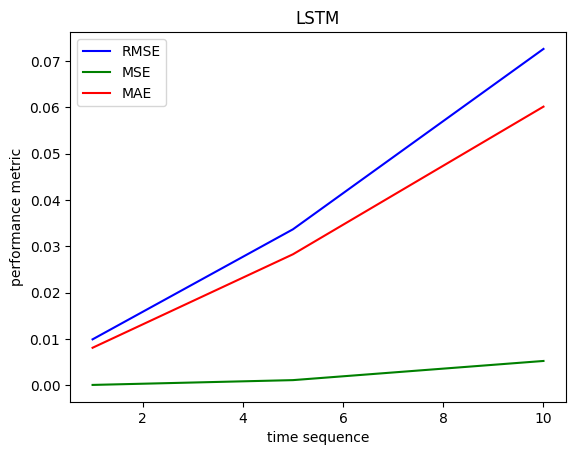

In [ ]:
# performance metric (RMSE,MSE,MAE) vs time sequence plot
time=[1,5,10]
#for epochs = 25
# mse=[0.0002379201865328094,0.0013674144239883422,0.0045660797399060425]
# rmse=[0.015424661634305286,0.03697856708944172,0.06757277365852346]
# mae=[0.013017792397830128,0.030849755866495947,0.05612290550160623]
#for epochs=50
mse=[9.856895376376315e-05,0.0011337481187699196,0.005267195836331034]
rmse=[0.00992818985332992,0.03367117637935924,0.07257544926716633]
mae=[0.00811284753401731,0.02828184810424981,0.06012553089206044]
plt.title('LSTM')
plt.plot(time,rmse,label='RMSE',color='b')
plt.plot(time,mse,label='MSE',color='g')
plt.plot(time,mae,label='MAE',color='r')
plt.xlabel('time sequence')
plt.ylabel('performance metric')
plt.legend()